<a href="https://colab.research.google.com/github/franmazzaro/7506R-2C2023-GRUPO39/blob/main/7506R_TP1_GRUPO39_CHP3_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, BallTree, KDTree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
import math as math

# Preprocesamiento

In [60]:
# Importamos el dataset que trabajamos en el checkpoint 2 con las varibles categóricas como dummies
reservas = pd.read_csv('/content/sample_data/reservas_dummies.csv')

# Importamos el dataset de test con las variables categóricas como dummies
test = pd.read_csv('/content/sample_data/test_dummies.csv')

In [61]:
# Droppeamos el id para poder entrenar y predecir
ids_train = reservas["id"]
ids_test = test["id"]
reservas.drop(columns="id", inplace=True)
test.drop(columns="id", inplace=True)

# Ordenamos las columnas
reservas = reservas.reindex(sorted(reservas.columns), axis=1)
test = test.reindex(sorted(test.columns), axis=1)

# Imputamos datos faltantes
test['agent'] = test['agent'].fillna(-1)
test['company'] = test['company'].fillna(-1)

# KNN classifier

In [62]:
a = reservas.drop(['is_canceled'], axis=1)
b = reservas['is_canceled']

x_train, x_test, y_train, y_test = train_test_split(a, b, test_size=0.20, random_state=0)

## Con parámetros default

In [63]:
#Crear el modelo
KNN_Classifier = KNeighborsClassifier()

#Vemos sus parámetros
KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [64]:
#Entrenar el modelo
KNN_Classifier.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier.predict(x_test)

### Métricas

In [65]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  8703
total:  11718


Text(50.722222222222214, 0.5, 'True')

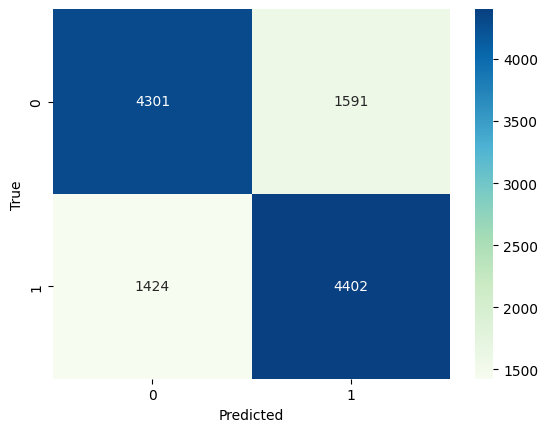

In [66]:
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [67]:
accuracy_score(y_test,y_pred)

0.7427035330261137

### Predicción sobre test

In [70]:
y_pred = KNN_Classifier.predict(test)
prediccion = pd.DataFrame({"id": ids_test, "is_canceled": y_pred})

In [72]:
prediccion.to_csv('/content/sample_data/prediccion_knn.csv', index = False)

## Con parámetros optimizados

In [75]:
#Métricas Válidas
VALID_METRICS = dict(
    ball_tree=BallTree.valid_metrics,
    kd_tree=KDTree.valid_metrics,
    # The following list comes from the sklearn.metrics.pairwise doc string
    brute=list(PAIRWISE_DISTANCE_FUNCTIONS.keys())
    + [ 'braycurtis','canberra','chebyshev','correlation',
        'cosine','dice','hamming','jaccard','kulsinski',
        'mahalanobis','matching','minkowski','rogerstanimoto',
        'russellrao','seuclidean','sokalmichener','sokalsneath',
        'sqeuclidean','yule','wminkowski',
    ],
)

#Ejemplo
for alg in VALID_METRICS:
    print(f'algoritmo: {alg}')
    print(VALID_METRICS[alg])
    print()

algoritmo: ball_tree
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'pyfunc']

algoritmo: kd_tree
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity']

algoritmo: brute
['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan', 'precomputed', 'nan_euclidean', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski']



In [ ]:
#Grilla de Parámetros
params_grid = {'n_neighbors':range(1,30),
               'weights':['distance','uniform'],
               'algorithm':['ball_tree', 'kd_tree', 'brute'],
               'metric':['euclidean','manhattan','chebyshev']
              }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='f1', n_iter=10, random_state=5)

rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

In [ ]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

### Métricas

In [ ]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_test)

#Accuracy test
accuracy_score(y_test,y_pred)

In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

### Predicción sobre test

In [ ]:
y_pred = KNN_Classifier.predict(test)
prediccion = pd.DataFrame({"id": ids_test, "is_canceled": y_pred})

In [ ]:
prediccion.to_csv('/content/sample_data/prediccion_knn_opt.csv', index = False)